In [1]:
#Development notes
#this script was last modified on 022917

#What this script does:
##Help you define C to get the best estimator 

##Run the model and get the precision and accuracy

##Test the significane of this model by permutation

##Plot a confusion matrix of the predictions

#Note: for this example I use a linear kernel and Leave One Out cross validation

In [20]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from decimal import Decimal
from sklearn.svm import SVC 
from sklearn.model_selection import *
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score 
from sklearn.pipeline import make_pipeline
from sklearn import metrics  
import numpy as np
import itertools
from itertools import cycle

In [3]:
#Load up your data
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

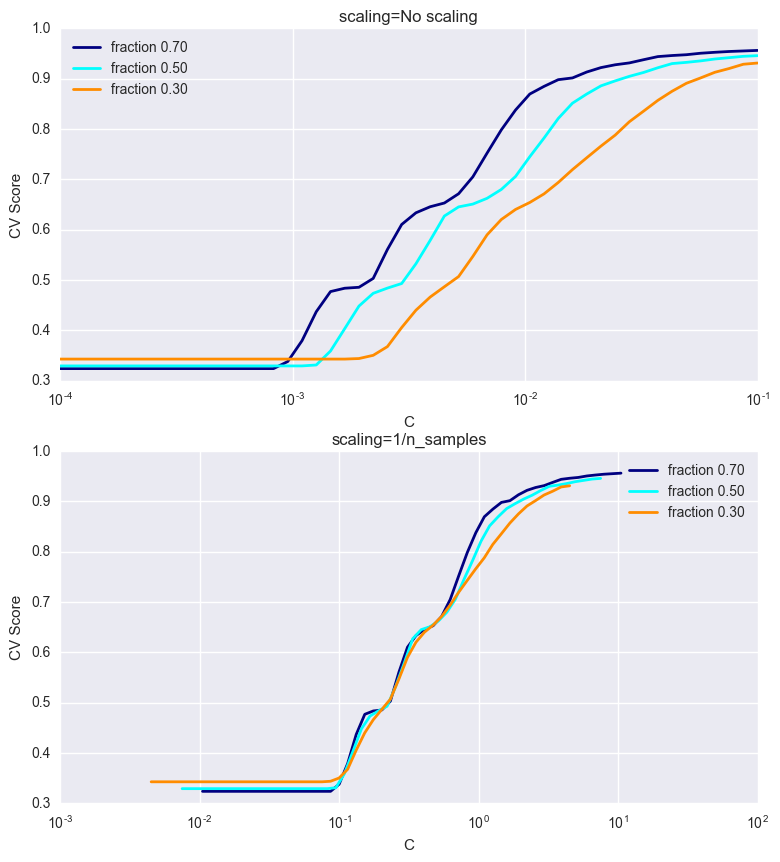

In [4]:
##Plot a range of C values to select best C to use for your model
## This code is Modified from 
##http://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html 
## Note that the timing of this step scales to the length of range of C values and the number of features
cRange=np.logspace(-4, -1)
n_samples=len(X)
clf_sets = [(SVC(C=1,kernel='linear'), cRange, X, y)]
colors = ['navy', 'cyan', 'darkorange']
lw = 2
for fignum, (clf, cs, X, y) in enumerate(clf_sets):
    # set up the plot for each regressor
    plt.figure(fignum, figsize=(9, 10))
    for k, train_size in enumerate(np.linspace(0.3, 0.7, 3)[::-1]):
        param_grid = dict(C=cs)
        # To get nice curve, we need a large number of iterations to
        # reduce the variance
        grid = GridSearchCV(clf, refit=False, param_grid=param_grid,
                            cv=ShuffleSplit(train_size=train_size,
                                            n_splits=250, random_state=1))
            
        try:
            grid.fit(X, y)
        #If the dataset is smaller all the test/train divisions might result in an error
        except ValueError:
            print("single classifier in train size ", train_size)
            break 
        scores = grid.cv_results_['mean_test_score']

        scales = [(1, 'No scaling'),
                    ((n_samples * train_size), '1/n_samples'),
                    ]

        for subplotnum, (scaler, name) in enumerate(scales):
            plt.subplot(2, 1, subplotnum + 1)
            plt.xlabel('C')
            plt.ylabel('CV Score')
            grid_cs = cs * float(scaler)  # scale the C's
            plt.semilogx(grid_cs, scores, label="fraction %.2f" %
                            train_size, color=colors[k], lw=lw)
            plt.title('scaling=%s' % name)
            plt.legend(loc="best")
plt.show()

In [15]:
#Choose best C from above
##Cross validate, here I use LeaveOneOut() 
##Then return predictions and scores
clf=SVC(C=0.1, kernel='linear')
predicted = cross_val_predict(clf, X, y, cv=LeaveOneOut())
score = cross_val_score(clf, X, y, cv=LeaveOneOut())
accuracy=metrics.accuracy_score(y, predicted)
print(accuracy)
mod=(predicted,score)

0.966666666667


Classification score 9.67E-01 (pvalue : 9.99E-04)


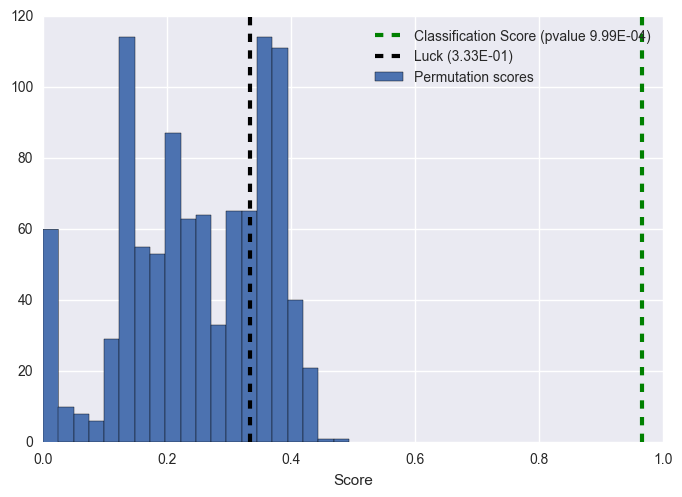

In [39]:
#Permute to test significance
##modified from 
##http://scikit-learn.org/stable/auto_examples/feature_selection/plot_permutation_test_for_classification.html#sphx-glr-auto-examples-feature-selection-plot-permutation-test-for-classification-py
##Note that the timing of this step scales to the number of permutations you run
n_classes = np.unique(y).size
score, permutation_scores, pvalue = permutation_test_score(
    clf, X, y, scoring="accuracy", cv=LeaveOneOut(), n_permutations=1000, n_jobs=1)
print("Classification score %s (pvalue : %s)" % (('%.2E' % (Decimal(score)),('%.2E' % (Decimal(pvalue))))))
# View histogram of permutation scores
plt.hist(permutation_scores, 20, label='Permutation scores')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
        label='Classification Score'
        ' (pvalue %s)' % ('%.2E' % (Decimal(pvalue))))
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, 
            label='Luck (%s)' % ('%.2E' % (Decimal(1. / n_classes))))
plt.ylim(ylim)
plt.legend(loc='best')
plt.xlabel('Score')
plt.show()

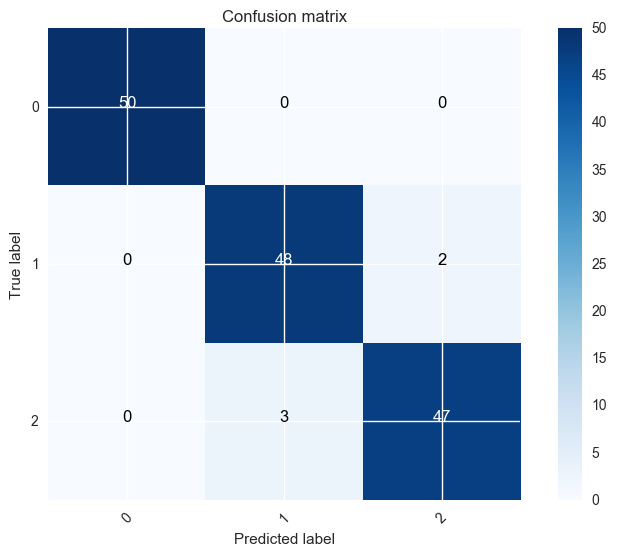

In [38]:
#Plot a confusion matrix
##modified from 
##http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#Note on significance testing
##Since the Iris dataset is a 3x3 not a 2x2 table you can not use the scipy.stats fisher exact test
###a mxn table can be used in R by saving the table below or using rpy2 & R magic
##If you have a lot of counts you can use a chi squared test, 
###but this is only recommended if each cell has a count of at least 5
classes = np.unique(y)
cm = confusion_matrix(y, mod[0])
np.set_printoptions(precision=2)
cmap=plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()